<a href="https://colab.research.google.com/github/devluanfelippe/demo1/blob/main/transfer_learning_40fotos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt


***Carregar e preparar os dados***


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Defina os caminhos das pastas
train_dir = '/content/drive/MyDrive/Dogs_vs_Cats/train'
validation_dir = '/content/drive/MyDrive/Dogs_vs_Cats/validation'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


***Pré-Processamento Dos Dados***

In [11]:
# Aumento de dados para treinamento
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Apenas redimensionamento para validação
validation_datagen = ImageDataGenerator(rescale=1./255)

# Tamanho do batch reduzido
batch_size = 8  # Ajustado para 8, já que você tem mais imagens agora

# Geradores de dados
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='binary'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='binary'
)

Found 40 images belonging to 2 classes.
Found 12 images belonging to 2 classes.


In [12]:
# Carregar o modelo VGG16 pré-treinado
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Congelar o modelo base
base_model.trainable = False

# Criar o modelo
model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),  # Dropout para evitar overfitting
    layers.Dense(1, activation='sigmoid')
])

# Compilar o modelo
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 4, 4, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │       2,097,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,812,353 (64.13 MB)

 Trainable params: 2,097,665 (8.00 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

 Carregando Modelo Pré-Treinado e Aplicando Transfer Learning
*

In [13]:
print(f'Número de imagens de treinamento: {train_generator.samples}')
print(f'Número de imagens de validação: {validation_generator.samples}')

Número de imagens de treinamento: 40
Número de imagens de validação: 12


In [14]:
# Early Stopping para evitar overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,  # Número de épocas sem melhoria antes de parar
    restore_best_weights=True
)

# Número de épocas reduzido
epochs = 10

# Treinar o modelo
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    callbacks=[early_stopping]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 28s 5s/step - accuracy: 0.5833 - loss: 0.7894 - val_accuracy: 0.7500 - val_loss: 0.6594
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 20s 5s/step - accuracy: 0.7042 - loss: 0.5672 - val_accuracy: 0.8750 - val_loss: 0.4628
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 14s 3s/step - accuracy: 0.8271 - loss: 0.4905 - val_accuracy: 0.6250 - val_loss: 0.6524
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.7469 - loss: 0.5615 - val_accuracy: 0.6250 - val_loss: 0.6295
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 40s 8s/step - accuracy: 0.8681 - loss: 0.3661 - val_accuracy: 0.7500 - val_loss: 0.5147


***Treinando o Modelo***

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.8889 - loss: 0.5007
Validação - Loss: 0.5410082936286926, Acurácia: 0.8333333134651184


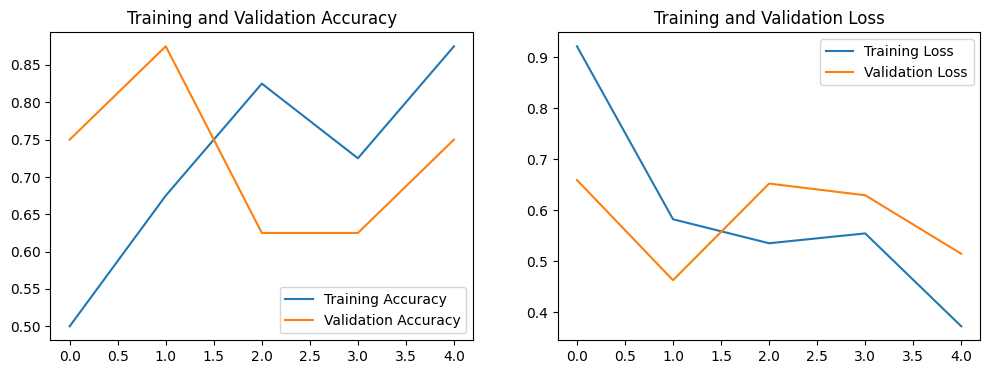

In [15]:
# Avaliar o modelo no conjunto de validação
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f'Validação - Loss: {val_loss}, Acurácia: {val_accuracy}')

# Plotar gráficos de acurácia e loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.show()